# Quantum Machine Learning challenge

Welcome to the Quantum Machine Learning challenge of the MQST Qiskit Fall Fest!

In this challenge, you will explore how quantum computing (QC) and machine learning (ML) can be brought toghether in the exciting field of Quantum Machine learning (QML). You will design a Quantum Neural Network to classify quantum data directly, as could obtained from a spin system.


In order to streamline the process of solving the challenge, we recommend you use the [qiskit-machine-learning library](https://qiskit-community.github.io/qiskit-machine-learning/index.html). **Keep in mind**, this library hasn't been updated to Qiskit 2.x! So just in case, we recommend you create a separate python environment for it.

## Challenge Overview
- Learn to classify example classical dataset using QNN:
    - Implement encoding
    - Design Parametrized Circuit
    - Measurement and Training

- Quantum Dataset: 
    - Implement Hamiltonian
    - Design QNN
    - Learn to classify phases of input states
    - Try different architechtures

In [ ]:
# Uncomment to install the necessary packages
# !pip install numpy
# !pip install scipy
# !pip install scikit-learn
# !pip install matplotlib
# !pip install jupyter
# !pip install qiskit[visualization]
# # For Local Linux or Mac, you can use the following command:
# # !pip install 'qiskit[visualization]'
# !pip install qiskit_algorithms
# !pip install qiskit_aer
# !pip install qiskit_ibm_runtime
# !pip install qiskit_ibm_transpiler
# !pip install qiskit_machine_learning   # Will reinstall qiskit in a lower version

## Introduction

If not of machine learning, everyone has heard of artificial intelligence. From humbler origins, to the current large language models, machine learning has permeated everything and become widespread. We will focus on the supervised learning paradigm. Simplifying, we look to solve a problem where we want to assign to each input $x$ some corresponding output $y = f(x)$. In fact this is a very general way to see any problem, so we note two distinct examples:
- An example is finding how many prime factors an integer has. This is a simple problem in the sense that we **know** how to express the $f$ that solves it, although that does not mean it is easy to do so efficiently. In this case, it has only been after Shor's quantum algorithm that this problem, previously thought of as computationally hard, has been "broken".
- A much different example is the task of classifying pictures of cats and dogs. In this case we know, or rather we assume, that there is some function that solves the problem because **we** can solve it. We can manually look at pictures and tell if it contains a cat or a dog. In spite of this, no one is able to come up with a simple and direct computer algorithm to solve this task.

It is for these latter kind of problems where supervised learning shines the most. The fundamental principle is that instead of trying to find this goal function $f$ directly, we take a generic parametrized guess. Now, exploiting that we can previously prepare some sample inputs/outputs (such as prelabelled cats and dogs pictures), we tweak our parameters to find the best fit. In fact, you have already done supervised learning before, as taking a linear regression is technically just that, where the guess (ansatz) is a linear function. Similarly, just as a linear regression will not directly work for a non linear problem, this choice of our ansatz is important for each problem.

On the other hand, quantum computing has emerged to find the physical limit of information processing, and ideas of combining it with machine learning happened soon after. There are many ways one can quantumly enhance machine learning, not just for show by putting the "quantum" in front. We will focus on using a parametrized quantum computer as ansatz for the problem solving function $f$, a so-called (abusing language) Quantum Neural Network. Your goal during this whole challenge is to design good models for quantum machine learning, which is still an ongoing research question while quantum resources are limited to perform big scale tests.

### A simple task

Consider the following simple problem. We have some data points and we want to distinguish them.


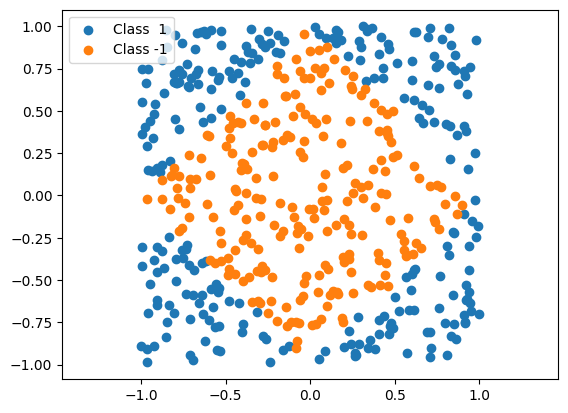

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
## Defining dataset:

np.random.seed(2025)

Nsamples = 500
R = 2 * np.random.random((Nsamples, 2)) - np.array([1, 1])  # Data points, each dimension random in [-1,1]

y = np.sum(np.abs(R) ** 1, axis=1) > 1  # Classification

R_classp1 = R[y]
R_classm1 = R[np.logical_not(y)]

plt.axis("equal")
plt.scatter(R_classp1[:, 0], R_classp1[:, 1], label="Class  1")
plt.scatter(R_classm1[:, 0], R_classm1[:, 1], label="Class -1")
plt.legend(loc="upper left")

In [ ]:
from sklearn.model_selection import train_test_split

# We split data into training set (to optimize directly) and test set (to check other points also get classified correctly)

seed = 2015

train_R, test_R, train_y, test_y = train_test_split(R, y, train_size=0.5, random_state=seed)

We will learn to classify points, by learning the underlying distribution $f(\vec{x}) = 1$, if $|\vec{x}| > 1$, -1 otherwise. To do this, we will first need a way to encode this classical data into our quantum computer. You can use Qiskit's simple `from qiskit.circuit.library import ZZFeatureMap`

In [ ]:
# Similar to https://qiskit-community.github.io/qiskit-machine-learning/tutorials/02a_training_a_quantum_model_on_a_real_dataset.html

In [170]:
## Your code here


Feel free to perform a deeper analysis, using a classical machine learning method to compare, or more elaborate QML schemes such as kernel methods, but this is a visual example of the kind of analysis you can do.

## Putting more quantum in Quantum Machine Learning

Your task will be to train a quantum machine learning model to classify which phase of matter corresponds to each input quantum state.

Imagine a spin system such as the  Haldane etc etc


- Solve the system classically to find some points


- Diagonalise

- Given initial data points

- Create Quantum Neural Network

- Train

- Compare graph

We are going to study now the XY model on a periodic chain, defined as 

$$H = -\sum^N_{j=1} \left [ \left(\frac{1+\gamma}{2}\right) \sigma^x_j \sigma^x_{j+1} + \left(\frac{1-\gamma}{2}\right) \sigma^y_j \sigma^y_{j+1}  + h \sigma^z_j \right],$$

with $\sigma_{N+1}=\sigma$.
It has the following simple phase diagram, where we will focus on the $h,\gamma>0$ region, with phase transitions at $h = 1$ and at the circular boundary $\gamma^2 + h^2 = 1$:

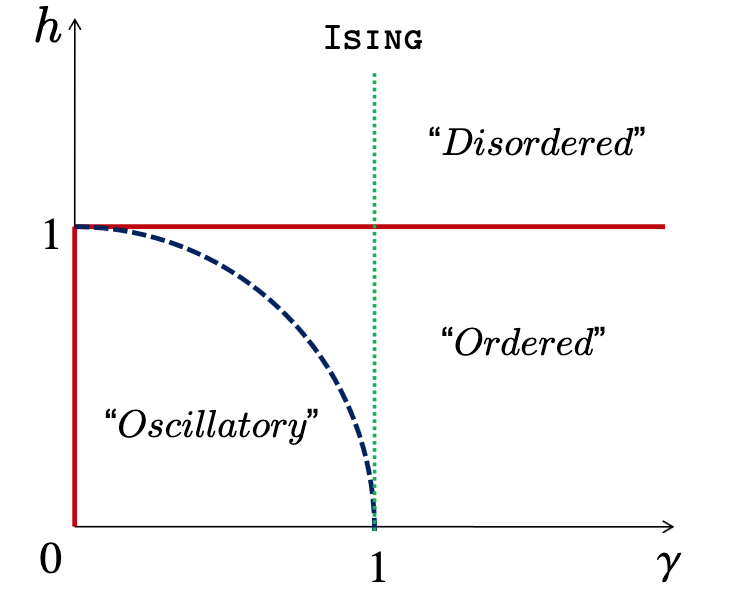

### Implement the hamiltonian


In [ ]:
from qiskit.quantum_info import SparsePauliOp
# Code here


def XY_hamiltonian(gamma: float, h: float) -> SparsePauliOp:
    # Your code here
    pass

Create a classical method to find the ground states of the hamiltonian
> hint: use libraries such as eigsh to diagonalise the hamiltonian with `.to_matrix()`

The steps are similar to the case before, but now the inputs do not need to be directly embeded into the quantum computer as they are already quantum states. You can use `.prepare_state()`. You can start simple, with N=6 qubits.

## Extra analysis
Here are some ideas to further develop your analysis of your model.




### Scalability
The fundamental principle that motivates quantum machine learning is the search for some quantum advantage with respect to classical machine learning. To simulate a generic quantum computer requires exponential time, although smart techniques such as tensor networks can dequantize simple or very structured circuits, so the ideal criterion is to have our models require at most polynomial resources with the number of qubits. You are invited to tackle this in any way you want, where the general idea is to scale the system for different sizes and see how it fares. Next we provide an example criterion that has become standard, the barren plateau phenomena.

It turns out that the expressability of quantum circuits, due to the exponential scaling of the Hilbert space, comes at a cost, many problems have gradients vanishing exponentially with number of qubits. Compute the gradients for random initial parameters of your circuits, and plot how they evolve

> Hint: If you just average the gradients, you may get 0, take averages of absolute values or compute the variance.


In [ ]:
# Code

### Unsupervised learning
Instead of learning to classify states, having been provided with the knowledge of the existing phases, try now to learn the phases themselves. That is, make an unsupervised quantum machine learning paradigm to identify the existence of the different phases the model has. You can use the same model as before, but if you reproduce the phases you may attempt to try it on another system. [This paper](https://arxiv.org/abs/2402.11022) presents an approach to this

## References
[1]. Challenges and Opportunities in Quantum Machine Learning

[2]. Noisy intermediate-scale quantum (NISQ) algorithms

[4] Franchini, Fabio. An introduction to integrable techniques for one-dimensional quantum systems. Vol. 940. Cham: Springer International Publishing, 2017. ([url](https://arxiv.org/abs/1609.02100))